# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-03-21 15:12:18.837532: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [2]:
tf.config.list_physical_devices()

2022-03-21 15:12:45.452895: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-03-21 15:12:45.453990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-03-21 15:12:45.454015: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-03-21 15:12:45.485348: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-03-21 15:12:45.497305: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-03-21 15:12:45.507387: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

er.so.10
2022-03-21 15:12:45.530080: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusparse.so.10
2022-03-21 15:12:45.557817: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-03-21 15:12:45.559595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1858] Adding visible gpu devices: 0


# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [3]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Al_alloy_4DSTEM_EM19064-2/20180727_112544-9cmCL-4Mx.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [4]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel


### Load in the Data

In [5]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [6]:
info = {}

In [7]:
nds = flatten_nav(sample.raw_data.data)

In [8]:
nds.shape

(261121, 256, 256)

In [9]:
ds = hs.load(dp)

In [11]:
from skimage.measure import shannon_entropy

entropy = np.zeros((sample.raw_data.data.shape[0:2]))

for i in range(ds.data.shape[0]):
    print(i)
    for j in range(ds.data.shape[1]):
        entropy[i,j] = shannon_entropy(ds.data[i,j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
data_patterns = flatten_nav(ds.data)

In [155]:
entr = flatten_nav(entropy**20)

In [156]:
sl_pdf = entr/ entr.sum()

<IPython.core.display.Javascript object>


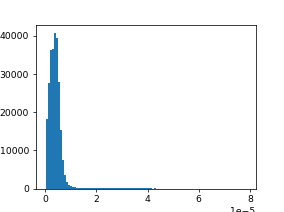

(array([1.8153e+04, 2.7689e+04, 3.6358e+04, 3.6621e+04, 4.0861e+04,
        3.9430e+04, 2.7905e+04, 1.5369e+04, 7.5060e+03, 3.6770e+03,
        1.8000e+03, 9.9100e+02, 6.3800e+02, 3.9200e+02, 3.0600e+02,
        2.3800e+02, 1.8800e+02, 1.5400e+02, 1.5600e+02, 1.4500e+02,
        1.1300e+02, 1.0100e+02, 1.1800e+02, 1.0700e+02, 8.0000e+01,
        9.3000e+01, 8.9000e+01, 9.1000e+01, 7.3000e+01, 7.5000e+01,
        8.6000e+01, 8.6000e+01, 6.4000e+01, 6.1000e+01, 5.6000e+01,
        8.0000e+01, 6.8000e+01, 5.6000e+01, 5.2000e+01, 5.8000e+01,
        4.6000e+01, 6.4000e+01, 4.6000e+01, 4.9000e+01, 5.4000e+01,
        4.2000e+01, 5.4000e+01, 3.6000e+01, 4.2000e+01, 3.6000e+01,
        3.4000e+01, 4.4000e+01, 3.0000e+01, 2.3000e+01, 3.2000e+01,
        2.3000e+01, 2.2000e+01, 1.6000e+01, 1.9000e+01, 1.5000e+01,
        1.5000e+01, 1.4000e+01, 2.3000e+01, 1.3000e+01, 1.8000e+01,
        1.6000e+01, 1.2000e+01, 6.0000e+00, 6.0000e+00, 1.2000e+01,
        1.0000e+01, 2.0000e+00, 1.0000e+01, 8.00

In [157]:
plt.figure()
plt.hist(sl_pdf,100)

In [160]:
choice_loc = np.zeros(data_patterns.shape[0])
for choice in np.random.choice(np.arange(data_patterns.shape[0]), 10000, True, sl_pdf):
    choice_loc[choice] += 1

<IPython.core.display.Javascript object>


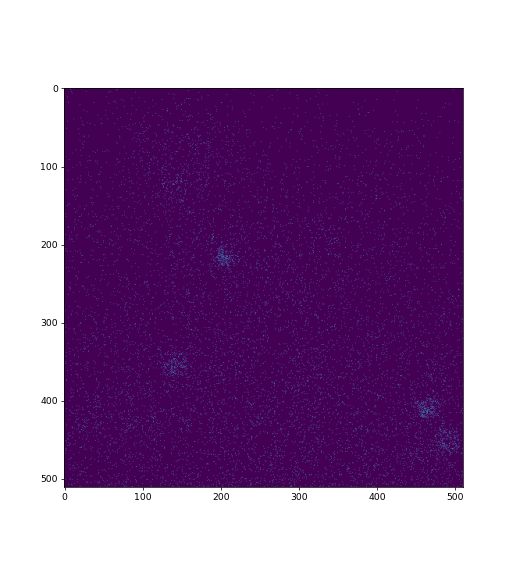

In [161]:
plt.figure()
plt.imshow(choice_loc.reshape(ds.data.shape[0:2]))

In [134]:
ind_locs[0].shape

(5000,)

In [162]:
mdps = []
nldps = []
for i in range(10):
    sdps = hs.signals.Signal2D(data_patterns[np.random.choice(np.arange(data_patterns.shape[0]), 5000, True, sl_pdf)])
    nldps.append(sdps.data)
    dpc = sdps.copy()
    dpc.add_poissonian_noise()
    mdps.append(dpc.data)
nds = flatten_nav(np.asarray(mdps))
nlds = flatten_nav(np.asarray(nldps))

In [163]:
input_data = data_manip_lowq(nds)
#np.random.shuffle(input_data)
#input_targets = data_manip_lowq(nlds)
val_data = data_manip_lowq(nds[::10])
np.random.shuffle(val_data)


started data manipulations
resized
started data manipulations
resized


<IPython.core.display.Javascript object>


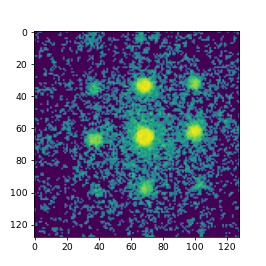

In [170]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
#plt.figure(figsize = (4,4))
#plt.imshow(input_targets[rand_patt])

##### Otherwise just skip

In [171]:
print(input_data.shape)

(50000, 128, 128)


In [172]:
batch_size = 2048

train_gen = Array_Generator(input_data, batch_size)#, target = input_targets)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


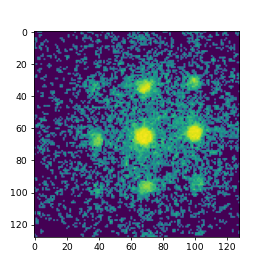

<IPython.core.display.Javascript object>


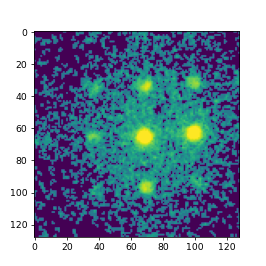

In [173]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])
plt.figure(figsize = (4,4))
plt.imshow(input_targets[rand_patt])

### Set the checkpointing

In [174]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [175]:
rebin_factor = 1

In [186]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [190]:
old_model ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-343-7.92353e+03.hdf5'

In [191]:
vae_model.load_weights(old_model)

### Train the Model

In [ ]:
history = vae_model.fit(train_gen, validation_data=valid_gen, epochs=10000, callbacks= [chkpoint_model])

Epoch 1/10000
25/25 [==============================] - ETA: 0s - loss: 7543.3501WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0352s vs `on_test_batch_end` time: 0.1821s). Check your callbacks.



Epoch 00001: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 533ms/step - loss: 7543.3501 - val_loss: 7534.9858
Epoch 2/10000
25/25 [==============================] - ETA: 0s - loss: 7520.2832
Epoch 00002: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 531ms/step - loss: 7520.2832 - val_loss: 7535.7202
Epoch 3/10000
25/25 [==============================] - ETA: 0s - loss: 7526.7153
Epoch 00003: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 531ms/step - loss: 7526.7153 - val_loss: 7534.4927
Epoch 4/10000
25/25 [==============================] - ETA: 0s - loss: 7532.1333
Epoch 00004: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 533ms/step - loss: 7532.1333 - val_loss: 7534.6655
Epoch 5/10000
25/25 [==============================] - ETA: 0s - loss: 7532.3818
Epoch 00005: val_loss did not improve from 7534.25342
25/25 [==============

Epoch 37/10000
25/25 [==============================] - ETA: 0s - loss: 7544.4370
Epoch 00037: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 530ms/step - loss: 7544.4370 - val_loss: 7534.3896
Epoch 38/10000
25/25 [==============================] - ETA: 0s - loss: 7539.7666
Epoch 00038: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 530ms/step - loss: 7539.7666 - val_loss: 7534.4951
Epoch 39/10000
25/25 [==============================] - ETA: 0s - loss: 7531.0586
Epoch 00039: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 529ms/step - loss: 7531.0586 - val_loss: 7534.4326
Epoch 40/10000
25/25 [==============================] - ETA: 0s - loss: 7536.2666
Epoch 00040: val_loss did not improve from 7534.25342
25/25 [==============================] - 13s 526ms/step - loss: 7536.2666 - val_loss: 7534.4175
Epoch 41/10000
25/25 [==============================] - ETA: 0s - loss: 

Epoch 72/10000
25/25 [==============================] - ETA: 0s - loss: 7538.0693
Epoch 00072: val_loss did not improve from 7534.20947
25/25 [==============================] - 13s 531ms/step - loss: 7538.0693 - val_loss: 7534.5288
Epoch 73/10000
25/25 [==============================] - ETA: 0s - loss: 7533.0483
Epoch 00073: val_loss did not improve from 7534.20947
25/25 [==============================] - 13s 534ms/step - loss: 7533.0483 - val_loss: 7534.4448
Epoch 74/10000
25/25 [==============================] - ETA: 0s - loss: 7532.4414
Epoch 00074: val_loss did not improve from 7534.20947
25/25 [==============================] - 13s 534ms/step - loss: 7532.4414 - val_loss: 7535.0225
Epoch 75/10000
25/25 [==============================] - ETA: 0s - loss: 7546.3418
Epoch 00075: val_loss did not improve from 7534.20947
25/25 [==============================] - 13s 534ms/step - loss: 7546.3418 - val_loss: 7535.0166
Epoch 76/10000
25/25 [==============================] - ETA: 0s - loss: 

Epoch 106/10000
25/25 [==============================] - ETA: 0s - loss: 7538.0889
Epoch 00106: val_loss did not improve from 7534.12305
25/25 [==============================] - 13s 529ms/step - loss: 7538.0889 - val_loss: 7534.2017
Epoch 107/10000
25/25 [==============================] - ETA: 0s - loss: 7529.4722
Epoch 00107: val_loss did not improve from 7534.12305
25/25 [==============================] - 13s 528ms/step - loss: 7529.4722 - val_loss: 7534.2954
Epoch 108/10000
25/25 [==============================] - ETA: 0s - loss: 7519.0771
Epoch 00108: val_loss did not improve from 7534.12305
25/25 [==============================] - 13s 529ms/step - loss: 7519.0771 - val_loss: 7534.8623
Epoch 109/10000
25/25 [==============================] - ETA: 0s - loss: 7537.3809
Epoch 00109: val_loss did not improve from 7534.12305
25/25 [==============================] - 13s 529ms/step - loss: 7537.3809 - val_loss: 7534.2046
Epoch 110/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7532.3682
Epoch 00139: val_loss did not improve from 7533.91699
25/25 [==============================] - 13s 529ms/step - loss: 7532.3682 - val_loss: 7534.0103
Epoch 140/10000
25/25 [==============================] - ETA: 0s - loss: 7529.8838
Epoch 00140: val_loss did not improve from 7533.91699
25/25 [==============================] - 13s 529ms/step - loss: 7529.8838 - val_loss: 7535.0688
Epoch 141/10000
25/25 [==============================] - ETA: 0s - loss: 7536.2480
Epoch 00141: val_loss did not improve from 7533.91699
25/25 [==============================] - 13s 537ms/step - loss: 7536.2480 - val_loss: 7534.4224
Epoch 142/10000
25/25 [==============================] - ETA: 0s - loss: 7537.6118
Epoch 00142: val_loss did not improve from 7533.91699
25/25 [==============================] - 13s 532ms/step - loss: 7537.6118 - val_loss: 7534.1895
Epoch 143/10000
25/25 [==============================] - ETA: 0s - loss: 7538.0308
E

25/25 [==============================] - ETA: 0s - loss: 7539.3081
Epoch 00173: val_loss did not improve from 7533.84863
25/25 [==============================] - 13s 530ms/step - loss: 7539.3081 - val_loss: 7534.1655
Epoch 174/10000
25/25 [==============================] - ETA: 0s - loss: 7542.5889
Epoch 00174: val_loss did not improve from 7533.84863
25/25 [==============================] - 13s 528ms/step - loss: 7542.5889 - val_loss: 7534.0566
Epoch 175/10000
25/25 [==============================] - ETA: 0s - loss: 7526.5322
Epoch 00175: val_loss did not improve from 7533.84863
25/25 [==============================] - 13s 530ms/step - loss: 7526.5322 - val_loss: 7535.1558
Epoch 176/10000
25/25 [==============================] - ETA: 0s - loss: 7519.1421
Epoch 00176: val_loss did not improve from 7533.84863
25/25 [==============================] - 13s 529ms/step - loss: 7519.1421 - val_loss: 7534.4727
Epoch 177/10000
25/25 [==============================] - ETA: 0s - loss: 7535.6304
E

Epoch 207/10000
25/25 [==============================] - ETA: 0s - loss: 7535.7280
Epoch 00207: val_loss did not improve from 7533.60547
25/25 [==============================] - 13s 529ms/step - loss: 7535.7280 - val_loss: 7536.3145
Epoch 208/10000
25/25 [==============================] - ETA: 0s - loss: 7531.9136
Epoch 00208: val_loss did not improve from 7533.60547
25/25 [==============================] - 13s 529ms/step - loss: 7531.9136 - val_loss: 7533.7026
Epoch 209/10000
25/25 [==============================] - ETA: 0s - loss: 7538.8535
Epoch 00209: val_loss did not improve from 7533.60547
25/25 [==============================] - 13s 530ms/step - loss: 7538.8535 - val_loss: 7533.9424
Epoch 210/10000
25/25 [==============================] - ETA: 0s - loss: 7518.8823
Epoch 00210: val_loss did not improve from 7533.60547
25/25 [==============================] - 13s 529ms/step - loss: 7518.8823 - val_loss: 7534.0527
Epoch 211/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7536.9458
Epoch 00240: val_loss did not improve from 7533.48242
25/25 [==============================] - 13s 530ms/step - loss: 7536.9458 - val_loss: 7533.8271
Epoch 241/10000
25/25 [==============================] - ETA: 0s - loss: 7524.9795
Epoch 00241: val_loss improved from 7533.48242 to 7533.44092, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-241-7.53344e+03.hdf5
25/25 [==============================] - 13s 536ms/step - loss: 7524.9795 - val_loss: 7533.4409
Epoch 242/10000
25/25 [==============================] - ETA: 0s - loss: 7533.4600
Epoch 00242: val_loss did not improve from 7533.44092
25/25 [==============================] - 13s 528ms/step - loss: 7533.4600 - val_loss: 7534.8472
Epoch 243/10000
25/25 [==============================] - ETA: 0s - loss: 7537.5718
Epoch 00243: val_loss did not improve from 7533.44092
25/25 [==============================]

Epoch 274/10000
25/25 [==============================] - ETA: 0s - loss: 7519.2671
Epoch 00274: val_loss did not improve from 7533.35205
25/25 [==============================] - 13s 529ms/step - loss: 7519.2671 - val_loss: 7534.4727
Epoch 275/10000
25/25 [==============================] - ETA: 0s - loss: 7536.3364
Epoch 00275: val_loss did not improve from 7533.35205
25/25 [==============================] - 13s 530ms/step - loss: 7536.3364 - val_loss: 7534.1025
Epoch 276/10000
25/25 [==============================] - ETA: 0s - loss: 7531.7896
Epoch 00276: val_loss did not improve from 7533.35205
25/25 [==============================] - 13s 530ms/step - loss: 7531.7896 - val_loss: 7533.6626
Epoch 277/10000
25/25 [==============================] - ETA: 0s - loss: 7531.7534
Epoch 00277: val_loss did not improve from 7533.35205
25/25 [==============================] - 13s 529ms/step - loss: 7531.7534 - val_loss: 7533.4126
Epoch 278/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7530.8359
Epoch 00307: val_loss did not improve from 7533.08496
25/25 [==============================] - 13s 530ms/step - loss: 7530.8359 - val_loss: 7533.6582
Epoch 308/10000
25/25 [==============================] - ETA: 0s - loss: 7535.5757
Epoch 00308: val_loss did not improve from 7533.08496
25/25 [==============================] - 13s 529ms/step - loss: 7535.5757 - val_loss: 7533.7368
Epoch 309/10000
25/25 [==============================] - ETA: 0s - loss: 7539.0405
Epoch 00309: val_loss did not improve from 7533.08496
25/25 [==============================] - 13s 529ms/step - loss: 7539.0405 - val_loss: 7533.9360
Epoch 310/10000
25/25 [==============================] - ETA: 0s - loss: 7532.0942
Epoch 00310: val_loss did not improve from 7533.08496
25/25 [==============================] - 13s 534ms/step - loss: 7532.0942 - val_loss: 7533.7134
Epoch 311/10000
25/25 [==============================] - ETA: 0s - loss: 7543.7847
E

Epoch 342/10000
25/25 [==============================] - ETA: 0s - loss: 7530.6313
Epoch 00342: val_loss did not improve from 7533.03369
25/25 [==============================] - 13s 529ms/step - loss: 7530.6313 - val_loss: 7533.3862
Epoch 343/10000
25/25 [==============================] - ETA: 0s - loss: 7525.5605
Epoch 00343: val_loss did not improve from 7533.03369
25/25 [==============================] - 13s 529ms/step - loss: 7525.5605 - val_loss: 7534.3882
Epoch 344/10000
25/25 [==============================] - ETA: 0s - loss: 7536.8423
Epoch 00344: val_loss did not improve from 7533.03369
25/25 [==============================] - 13s 531ms/step - loss: 7536.8423 - val_loss: 7534.9048
Epoch 345/10000
25/25 [==============================] - ETA: 0s - loss: 7536.7773
Epoch 00345: val_loss did not improve from 7533.03369
25/25 [==============================] - 13s 534ms/step - loss: 7536.7773 - val_loss: 7534.3159
Epoch 346/10000
25/25 [==============================] - ETA: 0s - l

Epoch 377/10000
25/25 [==============================] - ETA: 0s - loss: 7518.0747
Epoch 00377: val_loss improved from 7532.98877 to 7532.86621, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-377-7.53287e+03.hdf5
25/25 [==============================] - 13s 535ms/step - loss: 7518.0747 - val_loss: 7532.8662
Epoch 378/10000
25/25 [==============================] - ETA: 0s - loss: 7531.2700
Epoch 00378: val_loss did not improve from 7532.86621
25/25 [==============================] - 13s 530ms/step - loss: 7531.2700 - val_loss: 7532.9775
Epoch 379/10000
25/25 [==============================] - ETA: 0s - loss: 7524.2285
Epoch 00379: val_loss improved from 7532.86621 to 7532.79688, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-379-7.53280e+03.hdf5
25/25 [==============================] - 13s 533ms/step - loss: 7524.2285 - val_loss: 7532.7969
Epoch 380/10000
2

Epoch 411/10000
25/25 [==============================] - ETA: 0s - loss: 7543.6035
Epoch 00411: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 530ms/step - loss: 7543.6035 - val_loss: 7533.7417
Epoch 412/10000
25/25 [==============================] - ETA: 0s - loss: 7536.5576
Epoch 00412: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 531ms/step - loss: 7536.5576 - val_loss: 7533.5391
Epoch 413/10000
25/25 [==============================] - ETA: 0s - loss: 7530.1641
Epoch 00413: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 529ms/step - loss: 7530.1641 - val_loss: 7533.7402
Epoch 414/10000
25/25 [==============================] - ETA: 0s - loss: 7536.5649
Epoch 00414: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 530ms/step - loss: 7536.5649 - val_loss: 7532.8638
Epoch 415/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7542.9946
Epoch 00446: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 532ms/step - loss: 7542.9946 - val_loss: 7534.0063
Epoch 447/10000
25/25 [==============================] - ETA: 0s - loss: 7530.6279
Epoch 00447: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 538ms/step - loss: 7530.6279 - val_loss: 7533.4346
Epoch 448/10000
25/25 [==============================] - ETA: 0s - loss: 7544.8623
Epoch 00448: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 539ms/step - loss: 7544.8623 - val_loss: 7533.4673
Epoch 449/10000
25/25 [==============================] - ETA: 0s - loss: 7528.5869
Epoch 00449: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 539ms/step - loss: 7528.5869 - val_loss: 7533.4561
Epoch 450/10000
25/25 [==============================] - ETA: 0s - loss: 7530.1851
E

25/25 [==============================] - ETA: 0s - loss: 7525.0479
Epoch 00481: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 530ms/step - loss: 7525.0479 - val_loss: 7533.4897
Epoch 482/10000
25/25 [==============================] - ETA: 0s - loss: 7532.4697
Epoch 00482: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 529ms/step - loss: 7532.4697 - val_loss: 7533.1558
Epoch 483/10000
25/25 [==============================] - ETA: 0s - loss: 7543.3452
Epoch 00483: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 529ms/step - loss: 7543.3452 - val_loss: 7533.2847
Epoch 484/10000
25/25 [==============================] - ETA: 0s - loss: 7542.4531
Epoch 00484: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 529ms/step - loss: 7542.4531 - val_loss: 7534.0303
Epoch 485/10000
25/25 [==============================] - ETA: 0s - loss: 7532.5879
E

25/25 [==============================] - ETA: 0s - loss: 7538.9766
Epoch 00516: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 530ms/step - loss: 7538.9766 - val_loss: 7533.6816
Epoch 517/10000
25/25 [==============================] - ETA: 0s - loss: 7518.3804
Epoch 00517: val_loss did not improve from 7532.79688
25/25 [==============================] - 13s 530ms/step - loss: 7518.3804 - val_loss: 7533.5830
Epoch 518/10000
25/25 [==============================] - ETA: 0s - loss: 7530.4395
Epoch 00518: val_loss improved from 7532.79688 to 7532.70020, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-518-7.53270e+03.hdf5
25/25 [==============================] - 13s 537ms/step - loss: 7530.4395 - val_loss: 7532.7002
Epoch 519/10000
25/25 [==============================] - ETA: 0s - loss: 7522.7612
Epoch 00519: val_loss did not improve from 7532.70020
25/25 [==============================]

Epoch 549/10000
25/25 [==============================] - ETA: 0s - loss: 7531.8647
Epoch 00549: val_loss did not improve from 7532.62256
25/25 [==============================] - 13s 528ms/step - loss: 7531.8647 - val_loss: 7532.7119
Epoch 550/10000
25/25 [==============================] - ETA: 0s - loss: 7532.3960
Epoch 00550: val_loss did not improve from 7532.62256
25/25 [==============================] - 13s 531ms/step - loss: 7532.3960 - val_loss: 7534.5312
Epoch 551/10000
25/25 [==============================] - ETA: 0s - loss: 7536.8579
Epoch 00551: val_loss did not improve from 7532.62256
25/25 [==============================] - 13s 529ms/step - loss: 7536.8579 - val_loss: 7532.9976
Epoch 552/10000
25/25 [==============================] - ETA: 0s - loss: 7539.4243
Epoch 00552: val_loss did not improve from 7532.62256
25/25 [==============================] - 13s 530ms/step - loss: 7539.4243 - val_loss: 7533.0249
Epoch 553/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7535.0063
Epoch 00584: val_loss did not improve from 7532.62256
25/25 [==============================] - 13s 527ms/step - loss: 7535.0063 - val_loss: 7533.0591
Epoch 585/10000
25/25 [==============================] - ETA: 0s - loss: 7531.0664
Epoch 00585: val_loss improved from 7532.62256 to 7532.49902, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-585-7.53250e+03.hdf5
25/25 [==============================] - 13s 540ms/step - loss: 7531.0664 - val_loss: 7532.4990
Epoch 586/10000
25/25 [==============================] - ETA: 0s - loss: 7536.0972
Epoch 00586: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7536.0972 - val_loss: 7532.7578
Epoch 587/10000
25/25 [==============================] - ETA: 0s - loss: 7538.2041
Epoch 00587: val_loss did not improve from 7532.49902
25/25 [==============================]

Epoch 619/10000
25/25 [==============================] - ETA: 0s - loss: 7525.3545
Epoch 00619: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7525.3545 - val_loss: 7534.1719
Epoch 620/10000
25/25 [==============================] - ETA: 0s - loss: 7531.6011
Epoch 00620: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 535ms/step - loss: 7531.6011 - val_loss: 7534.6050
Epoch 621/10000
25/25 [==============================] - ETA: 0s - loss: 7525.0137
Epoch 00621: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7525.0137 - val_loss: 7535.0806
Epoch 622/10000
25/25 [==============================] - ETA: 0s - loss: 7539.0879
Epoch 00622: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 533ms/step - loss: 7539.0879 - val_loss: 7536.4814
Epoch 623/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7532.6099
Epoch 00654: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 528ms/step - loss: 7532.6099 - val_loss: 7533.9585
Epoch 655/10000
25/25 [==============================] - ETA: 0s - loss: 7539.1934
Epoch 00655: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7539.1934 - val_loss: 7533.8594
Epoch 656/10000
25/25 [==============================] - ETA: 0s - loss: 7528.0220
Epoch 00656: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7528.0220 - val_loss: 7533.2690
Epoch 657/10000
25/25 [==============================] - ETA: 0s - loss: 7542.6621
Epoch 00657: val_loss did not improve from 7532.49902
25/25 [==============================] - 13s 529ms/step - loss: 7542.6621 - val_loss: 7532.7754
Epoch 658/10000
25/25 [==============================] - ETA: 0s - loss: 7529.7886
E

Epoch 689/10000
25/25 [==============================] - ETA: 0s - loss: 7540.3579
Epoch 00689: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 529ms/step - loss: 7540.3579 - val_loss: 7535.4102
Epoch 690/10000
25/25 [==============================] - ETA: 0s - loss: 7531.3823
Epoch 00690: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 528ms/step - loss: 7531.3823 - val_loss: 7534.5151
Epoch 691/10000
25/25 [==============================] - ETA: 0s - loss: 7543.7607
Epoch 00691: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 528ms/step - loss: 7543.7607 - val_loss: 7534.5742
Epoch 692/10000
25/25 [==============================] - ETA: 0s - loss: 7540.8359
Epoch 00692: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 533ms/step - loss: 7540.8359 - val_loss: 7534.7495
Epoch 693/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7531.1689
Epoch 00724: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 531ms/step - loss: 7531.1689 - val_loss: 7533.1870
Epoch 725/10000
25/25 [==============================] - ETA: 0s - loss: 7536.9902
Epoch 00725: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 530ms/step - loss: 7536.9902 - val_loss: 7533.0967
Epoch 726/10000
25/25 [==============================] - ETA: 0s - loss: 7533.5146
Epoch 00726: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 535ms/step - loss: 7533.5146 - val_loss: 7534.9678
Epoch 727/10000
25/25 [==============================] - ETA: 0s - loss: 7536.7407
Epoch 00727: val_loss did not improve from 7532.34229
25/25 [==============================] - 13s 536ms/step - loss: 7536.7407 - val_loss: 7533.6602
Epoch 728/10000
25/25 [==============================] - ETA: 0s - loss: 7542.3633
E

Epoch 759/10000
25/25 [==============================] - ETA: 0s - loss: 7542.6221
Epoch 00759: val_loss improved from 7532.23340 to 7532.14551, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/chk-759-7.53215e+03.hdf5
25/25 [==============================] - 13s 540ms/step - loss: 7542.6221 - val_loss: 7532.1455
Epoch 760/10000
25/25 [==============================] - ETA: 0s - loss: 7518.4229
Epoch 00760: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7518.4229 - val_loss: 7533.1826
Epoch 761/10000
25/25 [==============================] - ETA: 0s - loss: 7542.7295
Epoch 00761: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7542.7295 - val_loss: 7532.9272
Epoch 762/10000
25/25 [==============================] - ETA: 0s - loss: 7538.9810
Epoch 00762: val_loss did not improve from 7532.14551
25/25 [===============

Epoch 794/10000
25/25 [==============================] - ETA: 0s - loss: 7539.0508
Epoch 00794: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7539.0508 - val_loss: 7539.7920
Epoch 795/10000
25/25 [==============================] - ETA: 0s - loss: 7538.5967
Epoch 00795: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7538.5967 - val_loss: 7539.5400
Epoch 796/10000
25/25 [==============================] - ETA: 0s - loss: 7541.4878
Epoch 00796: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7541.4878 - val_loss: 7538.9761
Epoch 797/10000
25/25 [==============================] - ETA: 0s - loss: 7530.1177
Epoch 00797: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7530.1177 - val_loss: 7538.8008
Epoch 798/10000
25/25 [==============================] - ETA: 0s - l

25/25 [==============================] - ETA: 0s - loss: 7534.5088
Epoch 00829: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7534.5088 - val_loss: 7536.2974
Epoch 830/10000
25/25 [==============================] - ETA: 0s - loss: 7545.8486
Epoch 00830: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7545.8486 - val_loss: 7536.6841
Epoch 831/10000
25/25 [==============================] - ETA: 0s - loss: 7535.1143
Epoch 00831: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7535.1143 - val_loss: 7537.0073
Epoch 832/10000
25/25 [==============================] - ETA: 0s - loss: 7534.5625
Epoch 00832: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7534.5625 - val_loss: 7536.5728
Epoch 833/10000
25/25 [==============================] - ETA: 0s - loss: 7540.0942
E

25/25 [==============================] - ETA: 0s - loss: 7544.9888
Epoch 00864: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7544.9888 - val_loss: 7540.1826
Epoch 865/10000
25/25 [==============================] - ETA: 0s - loss: 7537.2002
Epoch 00865: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.2002 - val_loss: 7537.6816
Epoch 866/10000
25/25 [==============================] - ETA: 0s - loss: 7528.6167
Epoch 00866: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7528.6167 - val_loss: 7538.6001
Epoch 867/10000
25/25 [==============================] - ETA: 0s - loss: 7540.0034
Epoch 00867: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7540.0034 - val_loss: 7537.6152
Epoch 868/10000
25/25 [==============================] - ETA: 0s - loss: 7533.6240
E

25/25 [==============================] - ETA: 0s - loss: 7536.0278
Epoch 00899: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 538ms/step - loss: 7536.0278 - val_loss: 7537.1289
Epoch 900/10000
25/25 [==============================] - ETA: 0s - loss: 7540.7256
Epoch 00900: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7540.7256 - val_loss: 7537.0889
Epoch 901/10000
25/25 [==============================] - ETA: 0s - loss: 7539.2676
Epoch 00901: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7539.2676 - val_loss: 7537.0215
Epoch 902/10000
25/25 [==============================] - ETA: 0s - loss: 7533.9775
Epoch 00902: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7533.9775 - val_loss: 7537.0273
Epoch 903/10000
25/25 [==============================] - ETA: 0s - loss: 7537.3691
E

25/25 [==============================] - ETA: 0s - loss: 7535.9883
Epoch 00934: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7535.9883 - val_loss: 7539.7759
Epoch 935/10000
25/25 [==============================] - ETA: 0s - loss: 7544.7925
Epoch 00935: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7544.7925 - val_loss: 7539.9702
Epoch 936/10000
25/25 [==============================] - ETA: 0s - loss: 7550.2300
Epoch 00936: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7550.2300 - val_loss: 7539.6553
Epoch 937/10000
25/25 [==============================] - ETA: 0s - loss: 7544.5225
Epoch 00937: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7544.5225 - val_loss: 7539.3335
Epoch 938/10000
25/25 [==============================] - ETA: 0s - loss: 7535.4580
E

25/25 [==============================] - ETA: 0s - loss: 7549.5210
Epoch 00969: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7549.5210 - val_loss: 7537.9712
Epoch 970/10000
25/25 [==============================] - ETA: 0s - loss: 7542.9990
Epoch 00970: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7542.9990 - val_loss: 7537.7080
Epoch 971/10000
25/25 [==============================] - ETA: 0s - loss: 7530.4990
Epoch 00971: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7530.4990 - val_loss: 7537.9458
Epoch 972/10000
25/25 [==============================] - ETA: 0s - loss: 7544.7007
Epoch 00972: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7544.7007 - val_loss: 7538.2070
Epoch 973/10000
25/25 [==============================] - ETA: 0s - loss: 7536.3213
E

25/25 [==============================] - ETA: 0s - loss: 7536.2295
Epoch 01004: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7536.2295 - val_loss: 7536.9121
Epoch 1005/10000
25/25 [==============================] - ETA: 0s - loss: 7548.6553
Epoch 01005: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7548.6553 - val_loss: 7537.1343
Epoch 1006/10000
25/25 [==============================] - ETA: 0s - loss: 7538.7153
Epoch 01006: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7538.7153 - val_loss: 7536.9097
Epoch 1007/10000
25/25 [==============================] - ETA: 0s - loss: 7532.1426
Epoch 01007: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.1426 - val_loss: 7536.8462
Epoch 1008/10000
25/25 [==============================] - ETA: 0s - loss: 7548.74

25/25 [==============================] - ETA: 0s - loss: 7539.0576
Epoch 01039: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7539.0576 - val_loss: 7536.6030
Epoch 1040/10000
25/25 [==============================] - ETA: 0s - loss: 7528.5400
Epoch 01040: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7528.5400 - val_loss: 7536.1318
Epoch 1041/10000
25/25 [==============================] - ETA: 0s - loss: 7533.3735
Epoch 01041: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7533.3735 - val_loss: 7536.5161
Epoch 1042/10000
25/25 [==============================] - ETA: 0s - loss: 7534.1221
Epoch 01042: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7534.1221 - val_loss: 7536.2983
Epoch 1043/10000
25/25 [==============================] - ETA: 0s - loss: 7533.83

25/25 [==============================] - ETA: 0s - loss: 7552.3320
Epoch 01074: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7552.3320 - val_loss: 7544.6602
Epoch 1075/10000
25/25 [==============================] - ETA: 0s - loss: 7537.8994
Epoch 01075: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7537.8994 - val_loss: 7538.4551
Epoch 1076/10000
25/25 [==============================] - ETA: 0s - loss: 7536.2671
Epoch 01076: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7536.2671 - val_loss: 7537.2222
Epoch 1077/10000
25/25 [==============================] - ETA: 0s - loss: 7534.2129
Epoch 01077: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7534.2129 - val_loss: 7536.5039
Epoch 1078/10000
25/25 [==============================] - ETA: 0s - loss: 7539.40

25/25 [==============================] - ETA: 0s - loss: 7537.7065
Epoch 01109: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7537.7065 - val_loss: 7535.8809
Epoch 1110/10000
25/25 [==============================] - ETA: 0s - loss: 7532.3657
Epoch 01110: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7532.3657 - val_loss: 7535.6694
Epoch 1111/10000
25/25 [==============================] - ETA: 0s - loss: 7526.8833
Epoch 01111: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.8833 - val_loss: 7535.5537
Epoch 1112/10000
25/25 [==============================] - ETA: 0s - loss: 7533.9614
Epoch 01112: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7533.9614 - val_loss: 7535.6719
Epoch 1113/10000
25/25 [==============================] - ETA: 0s - loss: 7547.17

25/25 [==============================] - ETA: 0s - loss: 7526.8403
Epoch 01144: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7526.8403 - val_loss: 7535.6362
Epoch 1145/10000
25/25 [==============================] - ETA: 0s - loss: 7547.4277
Epoch 01145: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7547.4277 - val_loss: 7535.8921
Epoch 1146/10000
25/25 [==============================] - ETA: 0s - loss: 7533.4473
Epoch 01146: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7533.4473 - val_loss: 7535.7119
Epoch 1147/10000
25/25 [==============================] - ETA: 0s - loss: 7541.8799
Epoch 01147: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7541.8799 - val_loss: 7535.5889
Epoch 1148/10000
25/25 [==============================] - ETA: 0s - loss: 7538.18

25/25 [==============================] - ETA: 0s - loss: 7520.1450
Epoch 01179: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7520.1450 - val_loss: 7535.1240
Epoch 1180/10000
25/25 [==============================] - ETA: 0s - loss: 7526.5186
Epoch 01180: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.5186 - val_loss: 7535.3506
Epoch 1181/10000
25/25 [==============================] - ETA: 0s - loss: 7531.5630
Epoch 01181: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.5630 - val_loss: 7534.9878
Epoch 1182/10000
25/25 [==============================] - ETA: 0s - loss: 7545.5220
Epoch 01182: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7545.5220 - val_loss: 7535.2441
Epoch 1183/10000
25/25 [==============================] - ETA: 0s - loss: 7547.07

25/25 [==============================] - ETA: 0s - loss: 7520.0210
Epoch 01214: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7520.0210 - val_loss: 7535.1665
Epoch 1215/10000
25/25 [==============================] - ETA: 0s - loss: 7537.6470
Epoch 01215: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.6470 - val_loss: 7534.9233
Epoch 1216/10000
25/25 [==============================] - ETA: 0s - loss: 7540.1797
Epoch 01216: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7540.1797 - val_loss: 7535.3994
Epoch 1217/10000
25/25 [==============================] - ETA: 0s - loss: 7532.6367
Epoch 01217: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.6367 - val_loss: 7535.2710
Epoch 1218/10000
25/25 [==============================] - ETA: 0s - loss: 7520.02

25/25 [==============================] - ETA: 0s - loss: 7545.9014
Epoch 01249: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7545.9014 - val_loss: 7534.5122
Epoch 1250/10000
25/25 [==============================] - ETA: 0s - loss: 7531.4141
Epoch 01250: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7531.4141 - val_loss: 7534.7720
Epoch 1251/10000
25/25 [==============================] - ETA: 0s - loss: 7531.0308
Epoch 01251: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.0308 - val_loss: 7534.3984
Epoch 1252/10000
25/25 [==============================] - ETA: 0s - loss: 7531.5713
Epoch 01252: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7531.5713 - val_loss: 7534.7271
Epoch 1253/10000
25/25 [==============================] - ETA: 0s - loss: 7540.71

25/25 [==============================] - ETA: 0s - loss: 7540.9824
Epoch 01284: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7540.9824 - val_loss: 7534.6177
Epoch 1285/10000
25/25 [==============================] - ETA: 0s - loss: 7541.0835
Epoch 01285: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7541.0835 - val_loss: 7534.8271
Epoch 1286/10000
25/25 [==============================] - ETA: 0s - loss: 7546.1772
Epoch 01286: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7546.1772 - val_loss: 7534.7754
Epoch 1287/10000
25/25 [==============================] - ETA: 0s - loss: 7536.7563
Epoch 01287: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7536.7563 - val_loss: 7534.7822
Epoch 1288/10000
25/25 [==============================] - ETA: 0s - loss: 7532.57

25/25 [==============================] - ETA: 0s - loss: 7545.3779
Epoch 01319: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7545.3779 - val_loss: 7534.9927
Epoch 1320/10000
25/25 [==============================] - ETA: 0s - loss: 7544.3877
Epoch 01320: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7544.3877 - val_loss: 7534.2280
Epoch 1321/10000
25/25 [==============================] - ETA: 0s - loss: 7532.7124
Epoch 01321: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7532.7124 - val_loss: 7533.9775
Epoch 1322/10000
25/25 [==============================] - ETA: 0s - loss: 7540.8755
Epoch 01322: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7540.8755 - val_loss: 7534.4111
Epoch 1323/10000
25/25 [==============================] - ETA: 0s - loss: 7537.00

25/25 [==============================] - ETA: 0s - loss: 7531.4048
Epoch 01354: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.4048 - val_loss: 7533.9238
Epoch 1355/10000
25/25 [==============================] - ETA: 0s - loss: 7528.8633
Epoch 01355: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7528.8633 - val_loss: 7533.8320
Epoch 1356/10000
25/25 [==============================] - ETA: 0s - loss: 7536.7773
Epoch 01356: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7536.7773 - val_loss: 7533.8584
Epoch 1357/10000
25/25 [==============================] - ETA: 0s - loss: 7544.6973
Epoch 01357: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7544.6973 - val_loss: 7534.2056
Epoch 1358/10000
25/25 [==============================] - ETA: 0s - loss: 7532.15

25/25 [==============================] - ETA: 0s - loss: 7545.5620
Epoch 01389: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7545.5620 - val_loss: 7534.0938
Epoch 1390/10000
25/25 [==============================] - ETA: 0s - loss: 7537.0303
Epoch 01390: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.0303 - val_loss: 7534.2192
Epoch 1391/10000
25/25 [==============================] - ETA: 0s - loss: 7531.5479
Epoch 01391: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7531.5479 - val_loss: 7533.7607
Epoch 1392/10000
25/25 [==============================] - ETA: 0s - loss: 7518.7661
Epoch 01392: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7518.7661 - val_loss: 7533.8936
Epoch 1393/10000
25/25 [==============================] - ETA: 0s - loss: 7518.55

25/25 [==============================] - ETA: 0s - loss: 7529.4829
Epoch 01424: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7529.4829 - val_loss: 7537.7417
Epoch 1425/10000
25/25 [==============================] - ETA: 0s - loss: 7543.6709
Epoch 01425: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7543.6709 - val_loss: 7538.3110
Epoch 1426/10000
25/25 [==============================] - ETA: 0s - loss: 7544.3057
Epoch 01426: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7544.3057 - val_loss: 7537.5151
Epoch 1427/10000
25/25 [==============================] - ETA: 0s - loss: 7530.4585
Epoch 01427: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7530.4585 - val_loss: 7541.2632
Epoch 1428/10000
25/25 [==============================] - ETA: 0s - loss: 7522.91

25/25 [==============================] - ETA: 0s - loss: 7532.2344
Epoch 01459: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7532.2344 - val_loss: 7533.9424
Epoch 1460/10000
25/25 [==============================] - ETA: 0s - loss: 7531.7471
Epoch 01460: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7531.7471 - val_loss: 7534.3950
Epoch 1461/10000
25/25 [==============================] - ETA: 0s - loss: 7531.8184
Epoch 01461: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.8184 - val_loss: 7534.6343
Epoch 1462/10000
25/25 [==============================] - ETA: 0s - loss: 7532.5132
Epoch 01462: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7532.5132 - val_loss: 7534.2559
Epoch 1463/10000
25/25 [==============================] - ETA: 0s - loss: 7532.46

25/25 [==============================] - ETA: 0s - loss: 7537.1685
Epoch 01494: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.1685 - val_loss: 7533.5361
Epoch 1495/10000
25/25 [==============================] - ETA: 0s - loss: 7542.2778
Epoch 01495: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7542.2778 - val_loss: 7533.6592
Epoch 1496/10000
25/25 [==============================] - ETA: 0s - loss: 7531.9072
Epoch 01496: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.9072 - val_loss: 7533.9785
Epoch 1497/10000
25/25 [==============================] - ETA: 0s - loss: 7523.8926
Epoch 01497: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7523.8926 - val_loss: 7533.7822
Epoch 1498/10000
25/25 [==============================] - ETA: 0s - loss: 7545.45

25/25 [==============================] - ETA: 0s - loss: 7543.6602
Epoch 01529: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7543.6602 - val_loss: 7533.4561
Epoch 1530/10000
25/25 [==============================] - ETA: 0s - loss: 7525.8813
Epoch 01530: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7525.8813 - val_loss: 7533.7910
Epoch 1531/10000
25/25 [==============================] - ETA: 0s - loss: 7545.1138
Epoch 01531: val_loss did not improve from 7532.14551
25/25 [==============================] - 14s 544ms/step - loss: 7545.1138 - val_loss: 7533.7354
Epoch 1532/10000
25/25 [==============================] - ETA: 0s - loss: 7544.8960
Epoch 01532: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 540ms/step - loss: 7544.8960 - val_loss: 7533.4546
Epoch 1533/10000
25/25 [==============================] - ETA: 0s - loss: 7530.51

25/25 [==============================] - ETA: 0s - loss: 7541.3657
Epoch 01564: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7541.3657 - val_loss: 7534.6958
Epoch 1565/10000
25/25 [==============================] - ETA: 0s - loss: 7537.7183
Epoch 01565: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7537.7183 - val_loss: 7534.8350
Epoch 1566/10000
25/25 [==============================] - ETA: 0s - loss: 7543.0361
Epoch 01566: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7543.0361 - val_loss: 7534.6826
Epoch 1567/10000
25/25 [==============================] - ETA: 0s - loss: 7530.6401
Epoch 01567: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7530.6401 - val_loss: 7534.2446
Epoch 1568/10000
25/25 [==============================] - ETA: 0s - loss: 7532.60

25/25 [==============================] - ETA: 0s - loss: 7544.0415
Epoch 01599: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7544.0415 - val_loss: 7534.0850
Epoch 1600/10000
25/25 [==============================] - ETA: 0s - loss: 7542.3818
Epoch 01600: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7542.3818 - val_loss: 7533.6416
Epoch 1601/10000
25/25 [==============================] - ETA: 0s - loss: 7529.8369
Epoch 01601: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7529.8369 - val_loss: 7533.3618
Epoch 1602/10000
25/25 [==============================] - ETA: 0s - loss: 7529.4097
Epoch 01602: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7529.4097 - val_loss: 7534.3110
Epoch 1603/10000
25/25 [==============================] - ETA: 0s - loss: 7536.00

25/25 [==============================] - ETA: 0s - loss: 7521.9419
Epoch 01634: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7521.9419 - val_loss: 7536.7407
Epoch 1635/10000
25/25 [==============================] - ETA: 0s - loss: 7541.1548
Epoch 01635: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7541.1548 - val_loss: 7536.0200
Epoch 1636/10000
25/25 [==============================] - ETA: 0s - loss: 7544.7583
Epoch 01636: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7544.7583 - val_loss: 7534.2954
Epoch 1637/10000
25/25 [==============================] - ETA: 0s - loss: 7531.1836
Epoch 01637: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7531.1836 - val_loss: 7533.7217
Epoch 1638/10000
25/25 [==============================] - ETA: 0s - loss: 7531.82

25/25 [==============================] - ETA: 0s - loss: 7529.7534
Epoch 01669: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7529.7534 - val_loss: 7533.3218
Epoch 1670/10000
25/25 [==============================] - ETA: 0s - loss: 7530.2598
Epoch 01670: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7530.2598 - val_loss: 7533.2334
Epoch 1671/10000
25/25 [==============================] - ETA: 0s - loss: 7524.2837
Epoch 01671: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7524.2837 - val_loss: 7533.1055
Epoch 1672/10000
25/25 [==============================] - ETA: 0s - loss: 7532.0098
Epoch 01672: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.0098 - val_loss: 7533.6514
Epoch 1673/10000
25/25 [==============================] - ETA: 0s - loss: 7538.30

25/25 [==============================] - ETA: 0s - loss: 7531.6133
Epoch 01704: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.6133 - val_loss: 7534.0542
Epoch 1705/10000
25/25 [==============================] - ETA: 0s - loss: 7519.3101
Epoch 01705: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7519.3101 - val_loss: 7534.3770
Epoch 1706/10000
25/25 [==============================] - ETA: 0s - loss: 7525.8301
Epoch 01706: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7525.8301 - val_loss: 7534.8535
Epoch 1707/10000
25/25 [==============================] - ETA: 0s - loss: 7531.7563
Epoch 01707: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7531.7563 - val_loss: 7533.9937
Epoch 1708/10000
25/25 [==============================] - ETA: 0s - loss: 7532.62

25/25 [==============================] - ETA: 0s - loss: 7536.4424
Epoch 01739: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7536.4424 - val_loss: 7533.2104
Epoch 1740/10000
25/25 [==============================] - ETA: 0s - loss: 7530.6299
Epoch 01740: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7530.6299 - val_loss: 7533.1470
Epoch 1741/10000
25/25 [==============================] - ETA: 0s - loss: 7545.0293
Epoch 01741: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7545.0293 - val_loss: 7533.1855
Epoch 1742/10000
25/25 [==============================] - ETA: 0s - loss: 7530.1411
Epoch 01742: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7530.1411 - val_loss: 7532.9775
Epoch 1743/10000
25/25 [==============================] - ETA: 0s - loss: 7538.23

25/25 [==============================] - ETA: 0s - loss: 7547.4214
Epoch 01774: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7547.4214 - val_loss: 7536.2183
Epoch 1775/10000
25/25 [==============================] - ETA: 0s - loss: 7532.7046
Epoch 01775: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7532.7046 - val_loss: 7536.1738
Epoch 1776/10000
25/25 [==============================] - ETA: 0s - loss: 7520.6592
Epoch 01776: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7520.6592 - val_loss: 7535.8809
Epoch 1777/10000
25/25 [==============================] - ETA: 0s - loss: 7539.1636
Epoch 01777: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7539.1636 - val_loss: 7535.8530
Epoch 1778/10000
25/25 [==============================] - ETA: 0s - loss: 7533.95

25/25 [==============================] - ETA: 0s - loss: 7550.0229
Epoch 01809: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7550.0229 - val_loss: 7538.1782
Epoch 1810/10000
25/25 [==============================] - ETA: 0s - loss: 7540.3540
Epoch 01810: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7540.3540 - val_loss: 7537.7129
Epoch 1811/10000
25/25 [==============================] - ETA: 0s - loss: 7540.7114
Epoch 01811: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7540.7114 - val_loss: 7537.6138
Epoch 1812/10000
25/25 [==============================] - ETA: 0s - loss: 7536.6377
Epoch 01812: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7536.6377 - val_loss: 7537.5474
Epoch 1813/10000
25/25 [==============================] - ETA: 0s - loss: 7544.34

25/25 [==============================] - ETA: 0s - loss: 7529.2192
Epoch 01844: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7529.2192 - val_loss: 7536.5518
Epoch 1845/10000
25/25 [==============================] - ETA: 0s - loss: 7538.8408
Epoch 01845: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7538.8408 - val_loss: 7536.5337
Epoch 1846/10000
25/25 [==============================] - ETA: 0s - loss: 7538.6406
Epoch 01846: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7538.6406 - val_loss: 7536.3311
Epoch 1847/10000
25/25 [==============================] - ETA: 0s - loss: 7539.8730
Epoch 01847: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7539.8730 - val_loss: 7536.8262
Epoch 1848/10000
25/25 [==============================] - ETA: 0s - loss: 7521.83

25/25 [==============================] - ETA: 0s - loss: 7546.5547
Epoch 01879: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7546.5547 - val_loss: 7536.4058
Epoch 1880/10000
25/25 [==============================] - ETA: 0s - loss: 7547.9707
Epoch 01880: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7547.9707 - val_loss: 7535.8809
Epoch 1881/10000
25/25 [==============================] - ETA: 0s - loss: 7532.5269
Epoch 01881: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7532.5269 - val_loss: 7535.8784
Epoch 1882/10000
25/25 [==============================] - ETA: 0s - loss: 7539.8975
Epoch 01882: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7539.8975 - val_loss: 7536.0278
Epoch 1883/10000
25/25 [==============================] - ETA: 0s - loss: 7527.55

25/25 [==============================] - ETA: 0s - loss: 7534.9893
Epoch 01914: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7534.9893 - val_loss: 7535.6758
Epoch 1915/10000
25/25 [==============================] - ETA: 0s - loss: 7533.3994
Epoch 01915: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.3994 - val_loss: 7535.6006
Epoch 1916/10000
25/25 [==============================] - ETA: 0s - loss: 7526.0669
Epoch 01916: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7526.0669 - val_loss: 7535.7266
Epoch 1917/10000
25/25 [==============================] - ETA: 0s - loss: 7527.2046
Epoch 01917: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7527.2046 - val_loss: 7535.6104
Epoch 1918/10000
25/25 [==============================] - ETA: 0s - loss: 7534.77

25/25 [==============================] - ETA: 0s - loss: 7547.2075
Epoch 01949: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7547.2075 - val_loss: 7535.4751
Epoch 1950/10000
25/25 [==============================] - ETA: 0s - loss: 7540.9199
Epoch 01950: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7540.9199 - val_loss: 7535.5718
Epoch 1951/10000
25/25 [==============================] - ETA: 0s - loss: 7530.5977
Epoch 01951: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7530.5977 - val_loss: 7535.4609
Epoch 1952/10000
25/25 [==============================] - ETA: 0s - loss: 7520.6187
Epoch 01952: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7520.6187 - val_loss: 7535.5391
Epoch 1953/10000
25/25 [==============================] - ETA: 0s - loss: 7545.69

25/25 [==============================] - ETA: 0s - loss: 7538.0498
Epoch 01984: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7538.0498 - val_loss: 7535.4146
Epoch 1985/10000
25/25 [==============================] - ETA: 0s - loss: 7526.4810
Epoch 01985: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.4810 - val_loss: 7536.0352
Epoch 1986/10000
25/25 [==============================] - ETA: 0s - loss: 7534.0742
Epoch 01986: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7534.0742 - val_loss: 7535.5488
Epoch 1987/10000
25/25 [==============================] - ETA: 0s - loss: 7542.5142
Epoch 01987: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7542.5142 - val_loss: 7536.2544
Epoch 1988/10000
25/25 [==============================] - ETA: 0s - loss: 7545.47

25/25 [==============================] - ETA: 0s - loss: 7527.6382
Epoch 02019: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7527.6382 - val_loss: 7538.0698
Epoch 2020/10000
25/25 [==============================] - ETA: 0s - loss: 7536.0454
Epoch 02020: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7536.0454 - val_loss: 7538.0376
Epoch 2021/10000
25/25 [==============================] - ETA: 0s - loss: 7522.2871
Epoch 02021: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7522.2871 - val_loss: 7537.9775
Epoch 2022/10000
25/25 [==============================] - ETA: 0s - loss: 7547.8560
Epoch 02022: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7547.8560 - val_loss: 7537.9482
Epoch 2023/10000
25/25 [==============================] - ETA: 0s - loss: 7539.44

25/25 [==============================] - ETA: 0s - loss: 7535.0747
Epoch 02054: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7535.0747 - val_loss: 7536.9087
Epoch 2055/10000
25/25 [==============================] - ETA: 0s - loss: 7548.4844
Epoch 02055: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7548.4844 - val_loss: 7536.9082
Epoch 2056/10000
25/25 [==============================] - ETA: 0s - loss: 7535.0503
Epoch 02056: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7535.0503 - val_loss: 7536.9072
Epoch 2057/10000
25/25 [==============================] - ETA: 0s - loss: 7535.7856
Epoch 02057: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7535.7856 - val_loss: 7536.8823
Epoch 2058/10000
25/25 [==============================] - ETA: 0s - loss: 7538.55

25/25 [==============================] - ETA: 0s - loss: 7542.4634
Epoch 02089: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7542.4634 - val_loss: 7536.3799
Epoch 2090/10000
25/25 [==============================] - ETA: 0s - loss: 7533.7817
Epoch 02090: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7533.7817 - val_loss: 7536.4761
Epoch 2091/10000
25/25 [==============================] - ETA: 0s - loss: 7538.0151
Epoch 02091: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7538.0151 - val_loss: 7536.3384
Epoch 2092/10000
25/25 [==============================] - ETA: 0s - loss: 7538.0342
Epoch 02092: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7538.0342 - val_loss: 7536.3008
Epoch 2093/10000
25/25 [==============================] - ETA: 0s - loss: 7531.03

25/25 [==============================] - ETA: 0s - loss: 7538.2954
Epoch 02124: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7538.2954 - val_loss: 7536.3784
Epoch 2125/10000
25/25 [==============================] - ETA: 0s - loss: 7537.6260
Epoch 02125: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7537.6260 - val_loss: 7535.9272
Epoch 2126/10000
25/25 [==============================] - ETA: 0s - loss: 7533.4478
Epoch 02126: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.4478 - val_loss: 7536.1895
Epoch 2127/10000
25/25 [==============================] - ETA: 0s - loss: 7534.5513
Epoch 02127: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7534.5513 - val_loss: 7536.1870
Epoch 2128/10000
25/25 [==============================] - ETA: 0s - loss: 7534.23

25/25 [==============================] - ETA: 0s - loss: 7532.3433
Epoch 02159: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7532.3433 - val_loss: 7535.6274
Epoch 2160/10000
25/25 [==============================] - ETA: 0s - loss: 7534.5386
Epoch 02160: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7534.5386 - val_loss: 7535.5103
Epoch 2161/10000
25/25 [==============================] - ETA: 0s - loss: 7537.2358
Epoch 02161: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7537.2358 - val_loss: 7535.7080
Epoch 2162/10000
25/25 [==============================] - ETA: 0s - loss: 7545.9448
Epoch 02162: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7545.9448 - val_loss: 7535.4014
Epoch 2163/10000
25/25 [==============================] - ETA: 0s - loss: 7538.26

25/25 [==============================] - ETA: 0s - loss: 7545.3789
Epoch 02194: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7545.3789 - val_loss: 7535.3350
Epoch 2195/10000
25/25 [==============================] - ETA: 0s - loss: 7533.8545
Epoch 02195: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.8545 - val_loss: 7535.7920
Epoch 2196/10000
25/25 [==============================] - ETA: 0s - loss: 7537.5879
Epoch 02196: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.5879 - val_loss: 7535.6514
Epoch 2197/10000
25/25 [==============================] - ETA: 0s - loss: 7534.0107
Epoch 02197: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7534.0107 - val_loss: 7535.5674
Epoch 2198/10000
25/25 [==============================] - ETA: 0s - loss: 7537.60

25/25 [==============================] - ETA: 0s - loss: 7533.7256
Epoch 02229: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7533.7256 - val_loss: 7535.1016
Epoch 2230/10000
25/25 [==============================] - ETA: 0s - loss: 7540.2158
Epoch 02230: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7540.2158 - val_loss: 7535.2114
Epoch 2231/10000
25/25 [==============================] - ETA: 0s - loss: 7520.0767
Epoch 02231: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7520.0767 - val_loss: 7535.2080
Epoch 2232/10000
25/25 [==============================] - ETA: 0s - loss: 7547.0947
Epoch 02232: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7547.0947 - val_loss: 7535.6650
Epoch 2233/10000
25/25 [==============================] - ETA: 0s - loss: 7528.23

25/25 [==============================] - ETA: 0s - loss: 7536.6162
Epoch 02264: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7536.6162 - val_loss: 7534.7871
Epoch 2265/10000
25/25 [==============================] - ETA: 0s - loss: 7531.3086
Epoch 02265: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.3086 - val_loss: 7534.8506
Epoch 2266/10000
25/25 [==============================] - ETA: 0s - loss: 7534.1206
Epoch 02266: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 526ms/step - loss: 7534.1206 - val_loss: 7535.7007
Epoch 2267/10000
25/25 [==============================] - ETA: 0s - loss: 7531.4487
Epoch 02267: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.4487 - val_loss: 7534.9570
Epoch 2268/10000
25/25 [==============================] - ETA: 0s - loss: 7542.79

25/25 [==============================] - ETA: 0s - loss: 7532.1519
Epoch 02299: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.1519 - val_loss: 7534.9194
Epoch 2300/10000
25/25 [==============================] - ETA: 0s - loss: 7532.9956
Epoch 02300: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.9956 - val_loss: 7534.6943
Epoch 2301/10000
25/25 [==============================] - ETA: 0s - loss: 7525.6211
Epoch 02301: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7525.6211 - val_loss: 7534.5928
Epoch 2302/10000
25/25 [==============================] - ETA: 0s - loss: 7526.4463
Epoch 02302: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7526.4463 - val_loss: 7535.9570
Epoch 2303/10000
25/25 [==============================] - ETA: 0s - loss: 7536.86

25/25 [==============================] - ETA: 0s - loss: 7533.0757
Epoch 02334: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.0757 - val_loss: 7534.3198
Epoch 2335/10000
25/25 [==============================] - ETA: 0s - loss: 7536.3354
Epoch 02335: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7536.3354 - val_loss: 7534.3145
Epoch 2336/10000
25/25 [==============================] - ETA: 0s - loss: 7533.4502
Epoch 02336: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.4502 - val_loss: 7534.3423
Epoch 2337/10000
25/25 [==============================] - ETA: 0s - loss: 7537.3232
Epoch 02337: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7537.3232 - val_loss: 7534.3662
Epoch 2338/10000
25/25 [==============================] - ETA: 0s - loss: 7531.17

25/25 [==============================] - ETA: 0s - loss: 7536.8740
Epoch 02369: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7536.8740 - val_loss: 7534.2480
Epoch 2370/10000
25/25 [==============================] - ETA: 0s - loss: 7536.7358
Epoch 02370: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7536.7358 - val_loss: 7534.6118
Epoch 2371/10000
25/25 [==============================] - ETA: 0s - loss: 7531.9551
Epoch 02371: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7531.9551 - val_loss: 7534.5215
Epoch 2372/10000
25/25 [==============================] - ETA: 0s - loss: 7536.2061
Epoch 02372: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7536.2061 - val_loss: 7534.3130
Epoch 2373/10000
25/25 [==============================] - ETA: 0s - loss: 7529.28

25/25 [==============================] - ETA: 0s - loss: 7532.3120
Epoch 02404: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.3120 - val_loss: 7534.8350
Epoch 2405/10000
25/25 [==============================] - ETA: 0s - loss: 7525.8418
Epoch 02405: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7525.8418 - val_loss: 7534.2510
Epoch 2406/10000
25/25 [==============================] - ETA: 0s - loss: 7530.7842
Epoch 02406: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7530.7842 - val_loss: 7534.4487
Epoch 2407/10000
25/25 [==============================] - ETA: 0s - loss: 7529.2715
Epoch 02407: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7529.2715 - val_loss: 7534.2593
Epoch 2408/10000
25/25 [==============================] - ETA: 0s - loss: 7524.45

25/25 [==============================] - ETA: 0s - loss: 7532.9497
Epoch 02439: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.9497 - val_loss: 7534.2017
Epoch 2440/10000
25/25 [==============================] - ETA: 0s - loss: 7538.1460
Epoch 02440: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7538.1460 - val_loss: 7534.3926
Epoch 2441/10000
25/25 [==============================] - ETA: 0s - loss: 7530.7119
Epoch 02441: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7530.7119 - val_loss: 7534.4072
Epoch 2442/10000
25/25 [==============================] - ETA: 0s - loss: 7531.6035
Epoch 02442: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.6035 - val_loss: 7534.3320
Epoch 2443/10000
25/25 [==============================] - ETA: 0s - loss: 7545.71

25/25 [==============================] - ETA: 0s - loss: 7525.6265
Epoch 02474: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7525.6265 - val_loss: 7534.4946
Epoch 2475/10000
25/25 [==============================] - ETA: 0s - loss: 7533.7617
Epoch 02475: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7533.7617 - val_loss: 7535.0103
Epoch 2476/10000
25/25 [==============================] - ETA: 0s - loss: 7518.9766
Epoch 02476: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7518.9766 - val_loss: 7534.2710
Epoch 2477/10000
25/25 [==============================] - ETA: 0s - loss: 7533.0747
Epoch 02477: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7533.0747 - val_loss: 7534.3232
Epoch 2478/10000
25/25 [==============================] - ETA: 0s - loss: 7537.50

25/25 [==============================] - ETA: 0s - loss: 7544.4614
Epoch 02509: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7544.4614 - val_loss: 7537.8794
Epoch 2510/10000
25/25 [==============================] - ETA: 0s - loss: 7535.6997
Epoch 02510: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7535.6997 - val_loss: 7537.7144
Epoch 2511/10000
25/25 [==============================] - ETA: 0s - loss: 7535.1230
Epoch 02511: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 538ms/step - loss: 7535.1230 - val_loss: 7537.6206
Epoch 2512/10000
25/25 [==============================] - ETA: 0s - loss: 7534.1694
Epoch 02512: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7534.1694 - val_loss: 7538.2607
Epoch 2513/10000
25/25 [==============================] - ETA: 0s - loss: 7543.16

25/25 [==============================] - ETA: 0s - loss: 7534.5645
Epoch 02544: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7534.5645 - val_loss: 7536.7974
Epoch 2545/10000
25/25 [==============================] - ETA: 0s - loss: 7534.5171
Epoch 02545: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7534.5171 - val_loss: 7536.3022
Epoch 2546/10000
25/25 [==============================] - ETA: 0s - loss: 7535.4580
Epoch 02546: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7535.4580 - val_loss: 7536.6479
Epoch 2547/10000
25/25 [==============================] - ETA: 0s - loss: 7547.8306
Epoch 02547: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7547.8306 - val_loss: 7536.5615
Epoch 2548/10000
25/25 [==============================] - ETA: 0s - loss: 7532.43

25/25 [==============================] - ETA: 0s - loss: 7532.6445
Epoch 02579: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7532.6445 - val_loss: 7535.7969
Epoch 2580/10000
25/25 [==============================] - ETA: 0s - loss: 7539.0112
Epoch 02580: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7539.0112 - val_loss: 7536.0063
Epoch 2581/10000
25/25 [==============================] - ETA: 0s - loss: 7533.1934
Epoch 02581: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7533.1934 - val_loss: 7535.8711
Epoch 2582/10000
25/25 [==============================] - ETA: 0s - loss: 7532.8716
Epoch 02582: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7532.8716 - val_loss: 7535.8057
Epoch 2583/10000
25/25 [==============================] - ETA: 0s - loss: 7533.77

25/25 [==============================] - ETA: 0s - loss: 7525.6230
Epoch 02614: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7525.6230 - val_loss: 7535.5327
Epoch 2615/10000
25/25 [==============================] - ETA: 0s - loss: 7532.4790
Epoch 02615: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.4790 - val_loss: 7535.5024
Epoch 2616/10000
25/25 [==============================] - ETA: 0s - loss: 7546.6650
Epoch 02616: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7546.6650 - val_loss: 7535.5488
Epoch 2617/10000
25/25 [==============================] - ETA: 0s - loss: 7546.5972
Epoch 02617: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7546.5972 - val_loss: 7535.3311
Epoch 2618/10000
25/25 [==============================] - ETA: 0s - loss: 7531.60

25/25 [==============================] - ETA: 0s - loss: 7539.6138
Epoch 02649: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7539.6138 - val_loss: 7536.8506
Epoch 2650/10000
25/25 [==============================] - ETA: 0s - loss: 7534.7139
Epoch 02650: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7534.7139 - val_loss: 7537.3320
Epoch 2651/10000
25/25 [==============================] - ETA: 0s - loss: 7529.1011
Epoch 02651: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7529.1011 - val_loss: 7537.7871
Epoch 2652/10000
25/25 [==============================] - ETA: 0s - loss: 7532.2324
Epoch 02652: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.2324 - val_loss: 7537.4370
Epoch 2653/10000
25/25 [==============================] - ETA: 0s - loss: 7535.23

25/25 [==============================] - ETA: 0s - loss: 7526.0015
Epoch 02684: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7526.0015 - val_loss: 7536.2817
Epoch 2685/10000
25/25 [==============================] - ETA: 0s - loss: 7532.6646
Epoch 02685: val_loss did not improve from 7532.14551
25/25 [==============================] - 14s 540ms/step - loss: 7532.6646 - val_loss: 7536.6846
Epoch 2686/10000
25/25 [==============================] - ETA: 0s - loss: 7533.8276
Epoch 02686: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.8276 - val_loss: 7536.3545
Epoch 2687/10000
25/25 [==============================] - ETA: 0s - loss: 7538.5991
Epoch 02687: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7538.5991 - val_loss: 7535.8896
Epoch 2688/10000
25/25 [==============================] - ETA: 0s - loss: 7520.14

25/25 [==============================] - ETA: 0s - loss: 7540.4741
Epoch 02719: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7540.4741 - val_loss: 7535.3486
Epoch 2720/10000
25/25 [==============================] - ETA: 0s - loss: 7533.9268
Epoch 02720: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7533.9268 - val_loss: 7535.2290
Epoch 2721/10000
25/25 [==============================] - ETA: 0s - loss: 7534.9751
Epoch 02721: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 537ms/step - loss: 7534.9751 - val_loss: 7536.3374
Epoch 2722/10000
25/25 [==============================] - ETA: 0s - loss: 7527.6235
Epoch 02722: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 536ms/step - loss: 7527.6235 - val_loss: 7535.4097
Epoch 2723/10000
25/25 [==============================] - ETA: 0s - loss: 7542.24

25/25 [==============================] - ETA: 0s - loss: 7539.0034
Epoch 02754: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7539.0034 - val_loss: 7536.7783
Epoch 2755/10000
25/25 [==============================] - ETA: 0s - loss: 7540.1948
Epoch 02755: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7540.1948 - val_loss: 7535.1978
Epoch 2756/10000
25/25 [==============================] - ETA: 0s - loss: 7533.0903
Epoch 02756: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7533.0903 - val_loss: 7535.0254
Epoch 2757/10000
25/25 [==============================] - ETA: 0s - loss: 7532.0757
Epoch 02757: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7532.0757 - val_loss: 7534.9810
Epoch 2758/10000
25/25 [==============================] - ETA: 0s - loss: 7531.69

25/25 [==============================] - ETA: 0s - loss: 7520.3511
Epoch 02789: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7520.3511 - val_loss: 7535.8584
Epoch 2790/10000
25/25 [==============================] - ETA: 0s - loss: 7532.7017
Epoch 02790: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.7017 - val_loss: 7536.2754
Epoch 2791/10000
25/25 [==============================] - ETA: 0s - loss: 7533.2495
Epoch 02791: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7533.2495 - val_loss: 7535.3633
Epoch 2792/10000
25/25 [==============================] - ETA: 0s - loss: 7537.0908
Epoch 02792: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7537.0908 - val_loss: 7534.6689
Epoch 2793/10000
25/25 [==============================] - ETA: 0s - loss: 7519.59

25/25 [==============================] - ETA: 0s - loss: 7530.3823
Epoch 02824: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7530.3823 - val_loss: 7535.8384
Epoch 2825/10000
25/25 [==============================] - ETA: 0s - loss: 7533.8096
Epoch 02825: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7533.8096 - val_loss: 7535.4263
Epoch 2826/10000
25/25 [==============================] - ETA: 0s - loss: 7532.7388
Epoch 02826: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7532.7388 - val_loss: 7534.8057
Epoch 2827/10000
25/25 [==============================] - ETA: 0s - loss: 7531.3325
Epoch 02827: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7531.3325 - val_loss: 7535.1113
Epoch 2828/10000
25/25 [==============================] - ETA: 0s - loss: 7543.25

25/25 [==============================] - ETA: 0s - loss: 7527.6074
Epoch 02859: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7527.6074 - val_loss: 7535.1616
Epoch 2860/10000
25/25 [==============================] - ETA: 0s - loss: 7540.5908
Epoch 02860: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7540.5908 - val_loss: 7535.3706
Epoch 2861/10000
25/25 [==============================] - ETA: 0s - loss: 7533.5166
Epoch 02861: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7533.5166 - val_loss: 7535.5576
Epoch 2862/10000
25/25 [==============================] - ETA: 0s - loss: 7520.0166
Epoch 02862: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7520.0166 - val_loss: 7535.5752
Epoch 2863/10000
25/25 [==============================] - ETA: 0s - loss: 7519.58

25/25 [==============================] - ETA: 0s - loss: 7529.5015
Epoch 02894: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7529.5015 - val_loss: 7534.6177
Epoch 2895/10000
25/25 [==============================] - ETA: 0s - loss: 7533.5889
Epoch 02895: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7533.5889 - val_loss: 7534.5200
Epoch 2896/10000
25/25 [==============================] - ETA: 0s - loss: 7525.9639
Epoch 02896: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7525.9639 - val_loss: 7534.4346
Epoch 2897/10000
25/25 [==============================] - ETA: 0s - loss: 7543.3872
Epoch 02897: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7543.3872 - val_loss: 7534.8384
Epoch 2898/10000
25/25 [==============================] - ETA: 0s - loss: 7532.40

25/25 [==============================] - ETA: 0s - loss: 7526.0464
Epoch 02929: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7526.0464 - val_loss: 7534.7632
Epoch 2930/10000
25/25 [==============================] - ETA: 0s - loss: 7540.2988
Epoch 02930: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7540.2988 - val_loss: 7535.0742
Epoch 2931/10000
25/25 [==============================] - ETA: 0s - loss: 7545.6138
Epoch 02931: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7545.6138 - val_loss: 7534.7056
Epoch 2932/10000
25/25 [==============================] - ETA: 0s - loss: 7530.5923
Epoch 02932: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7530.5923 - val_loss: 7534.2930
Epoch 2933/10000
25/25 [==============================] - ETA: 0s - loss: 7546.01

25/25 [==============================] - ETA: 0s - loss: 7536.7808
Epoch 02964: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7536.7808 - val_loss: 7534.1030
Epoch 2965/10000
25/25 [==============================] - ETA: 0s - loss: 7532.3691
Epoch 02965: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.3691 - val_loss: 7533.8545
Epoch 2966/10000
25/25 [==============================] - ETA: 0s - loss: 7542.3115
Epoch 02966: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7542.3115 - val_loss: 7533.9336
Epoch 2967/10000
25/25 [==============================] - ETA: 0s - loss: 7532.5693
Epoch 02967: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.5693 - val_loss: 7533.8926
Epoch 2968/10000
25/25 [==============================] - ETA: 0s - loss: 7526.35

25/25 [==============================] - ETA: 0s - loss: 7543.9385
Epoch 02999: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7543.9385 - val_loss: 7535.6528
Epoch 3000/10000
25/25 [==============================] - ETA: 0s - loss: 7533.0093
Epoch 03000: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7533.0093 - val_loss: 7534.6401
Epoch 3001/10000
25/25 [==============================] - ETA: 0s - loss: 7544.5078
Epoch 03001: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7544.5078 - val_loss: 7536.0625
Epoch 3002/10000
25/25 [==============================] - ETA: 0s - loss: 7542.7173
Epoch 03002: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7542.7173 - val_loss: 7534.0518
Epoch 3003/10000
25/25 [==============================] - ETA: 0s - loss: 7537.50

25/25 [==============================] - ETA: 0s - loss: 7535.9688
Epoch 03034: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7535.9688 - val_loss: 7533.9146
Epoch 3035/10000
25/25 [==============================] - ETA: 0s - loss: 7530.2363
Epoch 03035: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7530.2363 - val_loss: 7533.9888
Epoch 3036/10000
25/25 [==============================] - ETA: 0s - loss: 7533.0195
Epoch 03036: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7533.0195 - val_loss: 7534.1338
Epoch 3037/10000
25/25 [==============================] - ETA: 0s - loss: 7532.7808
Epoch 03037: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7532.7808 - val_loss: 7534.1240
Epoch 3038/10000
25/25 [==============================] - ETA: 0s - loss: 7530.45

25/25 [==============================] - ETA: 0s - loss: 7531.1929
Epoch 03069: val_loss did not improve from 7532.14551
25/25 [==============================] - 14s 540ms/step - loss: 7531.1929 - val_loss: 7533.7305
Epoch 3070/10000
25/25 [==============================] - ETA: 0s - loss: 7525.6499
Epoch 03070: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 535ms/step - loss: 7525.6499 - val_loss: 7533.7266
Epoch 3071/10000
25/25 [==============================] - ETA: 0s - loss: 7531.2793
Epoch 03071: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7531.2793 - val_loss: 7533.5400
Epoch 3072/10000
25/25 [==============================] - ETA: 0s - loss: 7544.9790
Epoch 03072: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 538ms/step - loss: 7544.9790 - val_loss: 7533.6113
Epoch 3073/10000
25/25 [==============================] - ETA: 0s - loss: 7536.03

25/25 [==============================] - ETA: 0s - loss: 7544.6270
Epoch 03104: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7544.6270 - val_loss: 7534.7393
Epoch 3105/10000
25/25 [==============================] - ETA: 0s - loss: 7531.4868
Epoch 03105: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.4868 - val_loss: 7534.4126
Epoch 3106/10000
25/25 [==============================] - ETA: 0s - loss: 7532.1777
Epoch 03106: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.1777 - val_loss: 7534.5854
Epoch 3107/10000
25/25 [==============================] - ETA: 0s - loss: 7547.1836
Epoch 03107: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7547.1836 - val_loss: 7535.5298
Epoch 3108/10000
25/25 [==============================] - ETA: 0s - loss: 7520.24

25/25 [==============================] - ETA: 0s - loss: 7525.3535
Epoch 03139: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7525.3535 - val_loss: 7533.4521
Epoch 3140/10000
25/25 [==============================] - ETA: 0s - loss: 7535.4761
Epoch 03140: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7535.4761 - val_loss: 7533.3638
Epoch 3141/10000
25/25 [==============================] - ETA: 0s - loss: 7536.2451
Epoch 03141: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7536.2451 - val_loss: 7533.2432
Epoch 3142/10000
25/25 [==============================] - ETA: 0s - loss: 7536.1753
Epoch 03142: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7536.1753 - val_loss: 7533.3945
Epoch 3143/10000
25/25 [==============================] - ETA: 0s - loss: 7535.30

25/25 [==============================] - ETA: 0s - loss: 7525.1484
Epoch 03174: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7525.1484 - val_loss: 7534.9458
Epoch 3175/10000
25/25 [==============================] - ETA: 0s - loss: 7540.0981
Epoch 03175: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7540.0981 - val_loss: 7534.8208
Epoch 3176/10000
25/25 [==============================] - ETA: 0s - loss: 7544.5176
Epoch 03176: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7544.5176 - val_loss: 7534.4170
Epoch 3177/10000
25/25 [==============================] - ETA: 0s - loss: 7532.5879
Epoch 03177: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.5879 - val_loss: 7534.3247
Epoch 3178/10000
25/25 [==============================] - ETA: 0s - loss: 7536.56

25/25 [==============================] - ETA: 0s - loss: 7538.2207
Epoch 03209: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7538.2207 - val_loss: 7540.6328
Epoch 3210/10000
25/25 [==============================] - ETA: 0s - loss: 7539.7363
Epoch 03210: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7539.7363 - val_loss: 7540.3120
Epoch 3211/10000
25/25 [==============================] - ETA: 0s - loss: 7544.5869
Epoch 03211: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7544.5869 - val_loss: 7539.9697
Epoch 3212/10000
25/25 [==============================] - ETA: 0s - loss: 7539.2144
Epoch 03212: val_loss did not improve from 7532.14551
25/25 [==============================] - 14s 540ms/step - loss: 7539.2144 - val_loss: 7540.0098
Epoch 3213/10000
25/25 [==============================] - ETA: 0s - loss: 7552.64

25/25 [==============================] - ETA: 0s - loss: 7538.3208
Epoch 03244: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7538.3208 - val_loss: 7539.6040
Epoch 3245/10000
25/25 [==============================] - ETA: 0s - loss: 7531.2754
Epoch 03245: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.2754 - val_loss: 7539.2910
Epoch 3246/10000
25/25 [==============================] - ETA: 0s - loss: 7535.0322
Epoch 03246: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7535.0322 - val_loss: 7539.2520
Epoch 3247/10000
25/25 [==============================] - ETA: 0s - loss: 7536.1919
Epoch 03247: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7536.1919 - val_loss: 7539.2466
Epoch 3248/10000
25/25 [==============================] - ETA: 0s - loss: 7524.20

25/25 [==============================] - ETA: 0s - loss: 7547.1953
Epoch 03279: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7547.1953 - val_loss: 7538.3398
Epoch 3280/10000
25/25 [==============================] - ETA: 0s - loss: 7541.8022
Epoch 03280: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7541.8022 - val_loss: 7538.4575
Epoch 3281/10000
25/25 [==============================] - ETA: 0s - loss: 7537.5815
Epoch 03281: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.5815 - val_loss: 7538.3599
Epoch 3282/10000
25/25 [==============================] - ETA: 0s - loss: 7537.1938
Epoch 03282: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7537.1938 - val_loss: 7538.2690
Epoch 3283/10000
25/25 [==============================] - ETA: 0s - loss: 7535.47

25/25 [==============================] - ETA: 0s - loss: 7540.6606
Epoch 03314: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7540.6606 - val_loss: 7537.7998
Epoch 3315/10000
25/25 [==============================] - ETA: 0s - loss: 7536.0811
Epoch 03315: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7536.0811 - val_loss: 7537.7822
Epoch 3316/10000
25/25 [==============================] - ETA: 0s - loss: 7544.2231
Epoch 03316: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7544.2231 - val_loss: 7537.7417
Epoch 3317/10000
25/25 [==============================] - ETA: 0s - loss: 7530.1592
Epoch 03317: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7530.1592 - val_loss: 7537.7026
Epoch 3318/10000
25/25 [==============================] - ETA: 0s - loss: 7539.39

25/25 [==============================] - ETA: 0s - loss: 7547.5137
Epoch 03349: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7547.5137 - val_loss: 7537.1016
Epoch 3350/10000
25/25 [==============================] - ETA: 0s - loss: 7534.7549
Epoch 03350: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7534.7549 - val_loss: 7537.1519
Epoch 3351/10000
25/25 [==============================] - ETA: 0s - loss: 7538.7461
Epoch 03351: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7538.7461 - val_loss: 7537.0928
Epoch 3352/10000
25/25 [==============================] - ETA: 0s - loss: 7528.3960
Epoch 03352: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7528.3960 - val_loss: 7537.1743
Epoch 3353/10000
25/25 [==============================] - ETA: 0s - loss: 7535.45

25/25 [==============================] - ETA: 0s - loss: 7534.2764
Epoch 03384: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7534.2764 - val_loss: 7536.5176
Epoch 3385/10000
25/25 [==============================] - ETA: 0s - loss: 7526.5728
Epoch 03385: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.5728 - val_loss: 7536.5679
Epoch 3386/10000
25/25 [==============================] - ETA: 0s - loss: 7541.7080
Epoch 03386: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7541.7080 - val_loss: 7536.5698
Epoch 3387/10000
25/25 [==============================] - ETA: 0s - loss: 7535.3525
Epoch 03387: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7535.3525 - val_loss: 7537.1982
Epoch 3388/10000
25/25 [==============================] - ETA: 0s - loss: 7545.12

25/25 [==============================] - ETA: 0s - loss: 7532.4316
Epoch 03419: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7532.4316 - val_loss: 7536.0601
Epoch 3420/10000
25/25 [==============================] - ETA: 0s - loss: 7547.6919
Epoch 03420: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7547.6919 - val_loss: 7536.2207
Epoch 3421/10000
25/25 [==============================] - ETA: 0s - loss: 7546.2451
Epoch 03421: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7546.2451 - val_loss: 7536.0767
Epoch 3422/10000
25/25 [==============================] - ETA: 0s - loss: 7546.2456
Epoch 03422: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7546.2456 - val_loss: 7535.9570
Epoch 3423/10000
25/25 [==============================] - ETA: 0s - loss: 7525.89

25/25 [==============================] - ETA: 0s - loss: 7534.2310
Epoch 03454: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 539ms/step - loss: 7534.2310 - val_loss: 7535.5854
Epoch 3455/10000
25/25 [==============================] - ETA: 0s - loss: 7540.7061
Epoch 03455: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7540.7061 - val_loss: 7535.7158
Epoch 3456/10000
25/25 [==============================] - ETA: 0s - loss: 7534.1133
Epoch 03456: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 540ms/step - loss: 7534.1133 - val_loss: 7535.7358
Epoch 3457/10000
25/25 [==============================] - ETA: 0s - loss: 7537.6304
Epoch 03457: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 540ms/step - loss: 7537.6304 - val_loss: 7535.8042
Epoch 3458/10000
25/25 [==============================] - ETA: 0s - loss: 7533.87

25/25 [==============================] - ETA: 0s - loss: 7531.7144
Epoch 03489: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7531.7144 - val_loss: 7535.1865
Epoch 3490/10000
25/25 [==============================] - ETA: 0s - loss: 7541.7153
Epoch 03490: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7541.7153 - val_loss: 7535.2441
Epoch 3491/10000
25/25 [==============================] - ETA: 0s - loss: 7525.1875
Epoch 03491: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 533ms/step - loss: 7525.1875 - val_loss: 7535.2178
Epoch 3492/10000
25/25 [==============================] - ETA: 0s - loss: 7526.3887
Epoch 03492: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7526.3887 - val_loss: 7535.4536
Epoch 3493/10000
25/25 [==============================] - ETA: 0s - loss: 7538.72

25/25 [==============================] - ETA: 0s - loss: 7539.3306
Epoch 03524: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7539.3306 - val_loss: 7535.3872
Epoch 3525/10000
25/25 [==============================] - ETA: 0s - loss: 7546.4658
Epoch 03525: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7546.4658 - val_loss: 7535.2095
Epoch 3526/10000
25/25 [==============================] - ETA: 0s - loss: 7547.0508
Epoch 03526: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7547.0508 - val_loss: 7535.2144
Epoch 3527/10000
25/25 [==============================] - ETA: 0s - loss: 7533.1875
Epoch 03527: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7533.1875 - val_loss: 7535.0898
Epoch 3528/10000
25/25 [==============================] - ETA: 0s - loss: 7538.54

25/25 [==============================] - ETA: 0s - loss: 7537.7378
Epoch 03559: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7537.7378 - val_loss: 7534.7695
Epoch 3560/10000
25/25 [==============================] - ETA: 0s - loss: 7546.1660
Epoch 03560: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7546.1660 - val_loss: 7534.8218
Epoch 3561/10000
25/25 [==============================] - ETA: 0s - loss: 7532.9502
Epoch 03561: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.9502 - val_loss: 7534.8838
Epoch 3562/10000
25/25 [==============================] - ETA: 0s - loss: 7546.2397
Epoch 03562: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7546.2397 - val_loss: 7534.7295
Epoch 3563/10000
25/25 [==============================] - ETA: 0s - loss: 7525.89

25/25 [==============================] - ETA: 0s - loss: 7532.1201
Epoch 03594: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.1201 - val_loss: 7534.6602
Epoch 3595/10000
25/25 [==============================] - ETA: 0s - loss: 7532.6021
Epoch 03595: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7532.6021 - val_loss: 7534.9746
Epoch 3596/10000
25/25 [==============================] - ETA: 0s - loss: 7533.4741
Epoch 03596: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 534ms/step - loss: 7533.4741 - val_loss: 7534.6641
Epoch 3597/10000
25/25 [==============================] - ETA: 0s - loss: 7532.0850
Epoch 03597: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.0850 - val_loss: 7534.4263
Epoch 3598/10000
25/25 [==============================] - ETA: 0s - loss: 7546.14

25/25 [==============================] - ETA: 0s - loss: 7538.4346
Epoch 03629: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7538.4346 - val_loss: 7535.4160
Epoch 3630/10000
25/25 [==============================] - ETA: 0s - loss: 7526.6709
Epoch 03630: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.6709 - val_loss: 7534.8521
Epoch 3631/10000
25/25 [==============================] - ETA: 0s - loss: 7531.1309
Epoch 03631: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7531.1309 - val_loss: 7534.8384
Epoch 3632/10000
25/25 [==============================] - ETA: 0s - loss: 7534.4858
Epoch 03632: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 532ms/step - loss: 7534.4858 - val_loss: 7534.9937
Epoch 3633/10000
25/25 [==============================] - ETA: 0s - loss: 7519.41

25/25 [==============================] - ETA: 0s - loss: 7533.3481
Epoch 03664: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7533.3481 - val_loss: 7534.2119
Epoch 3665/10000
25/25 [==============================] - ETA: 0s - loss: 7533.8057
Epoch 03665: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7533.8057 - val_loss: 7534.7393
Epoch 3666/10000
25/25 [==============================] - ETA: 0s - loss: 7525.5347
Epoch 03666: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7525.5347 - val_loss: 7534.7441
Epoch 3667/10000
25/25 [==============================] - ETA: 0s - loss: 7529.2305
Epoch 03667: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 531ms/step - loss: 7529.2305 - val_loss: 7534.3818
Epoch 3668/10000
25/25 [==============================] - ETA: 0s - loss: 7531.93

25/25 [==============================] - ETA: 0s - loss: 7544.6089
Epoch 03699: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7544.6089 - val_loss: 7534.4570
Epoch 3700/10000
25/25 [==============================] - ETA: 0s - loss: 7537.3320
Epoch 03700: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7537.3320 - val_loss: 7534.2642
Epoch 3701/10000
25/25 [==============================] - ETA: 0s - loss: 7539.6147
Epoch 03701: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7539.6147 - val_loss: 7535.1489
Epoch 3702/10000
25/25 [==============================] - ETA: 0s - loss: 7545.7749
Epoch 03702: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7545.7749 - val_loss: 7534.4297
Epoch 3703/10000
25/25 [==============================] - ETA: 0s - loss: 7525.37

25/25 [==============================] - ETA: 0s - loss: 7532.5591
Epoch 03734: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.5591 - val_loss: 7534.0776
Epoch 3735/10000
25/25 [==============================] - ETA: 0s - loss: 7536.0220
Epoch 03735: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 526ms/step - loss: 7536.0220 - val_loss: 7534.1792
Epoch 3736/10000
25/25 [==============================] - ETA: 0s - loss: 7532.8213
Epoch 03736: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7532.8213 - val_loss: 7534.2769
Epoch 3737/10000
25/25 [==============================] - ETA: 0s - loss: 7525.8955
Epoch 03737: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 530ms/step - loss: 7525.8955 - val_loss: 7534.3862
Epoch 3738/10000
25/25 [==============================] - ETA: 0s - loss: 7533.55

25/25 [==============================] - ETA: 0s - loss: 7532.6401
Epoch 03769: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7532.6401 - val_loss: 7534.3296
Epoch 3770/10000
25/25 [==============================] - ETA: 0s - loss: 7524.9185
Epoch 03770: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 527ms/step - loss: 7524.9185 - val_loss: 7534.8647
Epoch 3771/10000
25/25 [==============================] - ETA: 0s - loss: 7538.9727
Epoch 03771: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 529ms/step - loss: 7538.9727 - val_loss: 7533.9678
Epoch 3772/10000
25/25 [==============================] - ETA: 0s - loss: 7526.4824
Epoch 03772: val_loss did not improve from 7532.14551
25/25 [==============================] - 13s 528ms/step - loss: 7526.4824 - val_loss: 7534.8042
Epoch 3773/10000
25/25 [==============================] - ETA: 0s - loss: 7531.15

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')